In [77]:
import os
import math
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc; gc.enable()
from collections import defaultdict

import skimage as skim
from skimage.io import imread
from skimage.util import montage2d as montage
from skimage.morphology import label

In [78]:
tf.logging.set_verbosity(tf.logging.ERROR)

## Set path variables

In [79]:
ship_dir = '.'
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')

## Get segmentation dataframe

In [80]:
masks = pd.read_csv('train_ship_segmentations_v2.csv')

## Define RLE functions

In [82]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    string = mask_rle.split()
    starts = np.asarray(string[0::2], dtype=int) # select indices starting from 0 with step 2
    lengths = np.asarray(string[1::2], dtype=int) # select indices starting from 1 with step 2
    starts -= 1 # since indices should start from 0 and input starts from 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [83]:
def multi_rle_encode(img, **kwargs):
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels == x, axis=2), **kwargs) for x in np.unique(labels[labels > 0])]
    else:
        return [rle_encode(labels == x, **kwargs) for x in np.unique(labels[labels > 0])]

In [84]:
def rle_encode(image):
    pixels = image.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1 # make indices start from 1 by adding 1
    runs[1::2] = runs[1::2] - runs[::2]
    return ' '.join(str(x) for x in runs)

In [85]:
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

def masks_plain(mask_list, shape=(768, 768)):

    all_masks = np.zeros(shape, dtype=np.uint8)

    for mask in mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
            #all_masks |= np.stack([x, np.invert(x > 1)], axis=-1)
    return all_masks

In [86]:
def masks_colored(mask_list, shape=(768, 768)):
    all_masks = np.zeros(shape, dtype=np.float)
    scale = lambda x: (len(mask_list) + x) / (len(mask_list) * 2)
    for i, mask in enumerate(mask_list):
        if isinstance(mask, str):
            all_masks = all_masks + scale(i) * rle_decode(mask)
    return all_masks

## Create train dataframe

In [87]:
not_empty = pd.notna(masks['EncodedPixels'])

print("{} masks in {} images".format(not_empty.sum(), masks[not_empty]['ImageId'].nunique()))
print("{} empty images in {} total images".format((~not_empty).sum(), masks['ImageId'].nunique()))

81723 masks in 42556 images
150000 empty images in 192556 total images


In [88]:
# create ships column

masks['ships'] = masks['EncodedPixels'].map(lambda row: 1 if isinstance(row, str) else 0)

### Create dataframe containing only unique image ids

In [89]:
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()

In [90]:
# create boolean 'has_ship' column

unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda ships: 1.0 if ships > 0 else 0.0)

In [91]:
# create image size column

unique_img_ids['img_size'] = unique_img_ids['ImageId'].map(
    lambda img_id: os.stat(os.path.join(train_image_dir, img_id)).st_size / 1024)

In [92]:
# drop image ids corresponding to files with size less than 50kb

unique_img_ids = unique_img_ids[unique_img_ids['img_size'] > 50]

In [93]:
masks.drop(columns='ships', inplace=True)

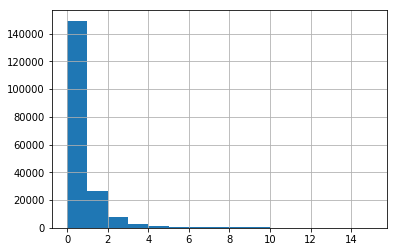

In [94]:
# get histogram for number of ships on image

unique_img_ids['ships'].hist(bins=unique_img_ids['ships'].max())

### Undersample ship_number classes

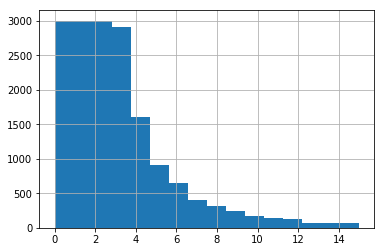

In [95]:
# group by ship count and undersampling

SAMPLES_PER_GROUP = 3000

train_data = unique_img_ids.groupby('ships').apply(
    lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)

train_data['ships'].hist(bins=unique_img_ids['ships'].max() + 1)

### Create { img_id : mask } dictionary

In [97]:
mask_dict = defaultdict(list)

for img, mask in zip(masks['ImageId'], masks['EncodedPixels']):
    if isinstance(mask, str):
        mask_dict[img].append(mask)

## Create numpy examples

In [98]:
def create_data(train_data, mask_dict, ratio=0.8, size=100):
    
    if ratio >= 1.0 or ratio <= 0.0:
        ratio = 0.8
    
    batch_ids = np.random.choice(train_data['ImageId'], size=size)
    
    examples = []
    labels = []
    
    for img_id in batch_ids:
        labels.append(masks_plain(mask_dict[img_id]))
        examples.append(imread(train_image_dir + '/' + img_id))
            #skim.exposure.adjust_sigmoid(imread(train_image_dir + '/' + img_id), cutoff=0.7, gain=100))
    
    train_size = int(len(examples) * ratio)
    
    train_exs = np.asarray(examples[:train_size], dtype=np.float32)
    valid_exs = np.asarray(examples[train_size:], dtype=np.float32)
    train_lbls = np.asarray(labels[:train_size], dtype=np.float32)
    valid_lbls = np.asarray(labels[train_size:], dtype=np.float32)
    
    return train_exs, train_lbls, valid_exs, valid_lbls

## Define deconvolution layer

In [99]:
def deconv2d(tensor, kernel, out_size, out_chan, in_chan, name, strides=[1,1,1,1]):
    input_shape = tf.shape(tensor)
    batch_size = input_shape[0]
    out_shape = tf.stack([batch_size, out_size, out_size, out_chan])
    filter_shape = [kernel, kernel, out_chan, in_chan]
    weights = tf.get_variable(name=name, shape=filter_shape)
    out_tensor = tf.nn.conv2d_transpose(tensor, weights, out_shape, strides, padding='SAME')
    return out_tensor

## U-Net model, dice loss

In [100]:
def cnn_model_fn(features, labels, mode):
    
    # (b * h * w * ch)
    
    # downscaling...
    
    conv_layer_1 = tf.layers.conv2d(
        inputs=features['x'], # (b * 768 * 768 * 3)
        filters=8,            # (b * 768 * 768 * 8)
        kernel_size=[1, 1],
        padding='same',
        activation=tf.nn.relu)
    
    pool_layer_1 = tf.layers.max_pooling2d(
        inputs = conv_layer_1, # (b * 768 * 768 * 8)
        pool_size = [2, 2],    # (b * 384 * 384 * 8)
        strides = 2,
        padding='valid')
    
    conv_layer_2 = tf.layers.conv2d(
        inputs=pool_layer_1, # (b * 384 * 384 * 8)
        filters=16,          # (b * 384 * 384 * 16)
        kernel_size=[3, 3],
        padding='same',
        activation=tf.nn.relu)
    
    pool_layer_2 = tf.layers.max_pooling2d(
        inputs = conv_layer_2, # (b * 384 * 384 * 16)
        pool_size = [2, 2],    # (b * 192 * 192 * 16)
        strides = 2,
        padding='valid')
    
    conv_layer_3 = tf.layers.conv2d(
        inputs=pool_layer_2, # (b * 192 * 192 * 16)
        filters=32,          # (b * 192 * 192 * 32)
        kernel_size=[3, 3],
        padding='same',
        activation=tf.nn.relu)
    
    pool_layer_3 = tf.layers.max_pooling2d(
        inputs = conv_layer_3, # (b * 192 * 192 * 32)
        pool_size = [2, 2],    # (b * 96 * 96 * 32)
        strides = 2,
        padding='valid')
    
    conv_layer_4 = tf.layers.conv2d(
        inputs=pool_layer_3, # (b * 96 * 96 * 32)
        filters=64,          # (b * 96 * 96 * 64)
        kernel_size=[3, 3],
        padding='same',
        activation=tf.nn.relu)
    
    pool_layer_4 = tf.layers.max_pooling2d(
        inputs = conv_layer_4, # (b * 96 * 96 * 64)
        pool_size = [2, 2],    # (b * 48 * 48 * 64)
        strides = 2,
        padding='valid')
    
    conv_layer_5 = tf.layers.conv2d(
        inputs=pool_layer_4, # (b * 48 * 48 * 64)
        filters=128,         # (b * 48 * 48 * 128)
        kernel_size=[3, 3],
        padding='same',
        activation=tf.nn.relu)
    
        
    deconv_layer_1 = deconv2d(conv_layer_5, 1, 48, 128, 128, 'deconv1') # (b * 48 * 48 * 128)
    deconv_layer_1 = tf.nn.relu(deconv_layer_1)
    
    # upscaling, using corresponding downscale layers...
    
    deconv_layer_2 = deconv2d(deconv_layer_1, 2, 96, 64, 128, 'deconv2', strides=[1,2,2,1]) # (b * 96 * 96 * 64)
    deconv_layer_2 = tf.concat([deconv_layer_2, conv_layer_4], axis=-1)                     # (b * 96 * 96 * 128)
    conv_layer_6 = tf.layers.conv2d(
        inputs=deconv_layer_2, # (b * 96 * 96 * 128)
        filters=64,            # (b * 96 * 96 * 64)
        kernel_size=[3, 3],
        padding='same',
        activation=tf.nn.relu)
    
    deconv_layer_3 = deconv2d(conv_layer_6, 2, 192, 32, 64, 'deconv3', strides=[1,2,2,1]) # (b * 192 * 192 * 32)
    deconv_layer_3 = tf.concat([deconv_layer_3, conv_layer_3], axis=-1)                   # (b * 192 * 192 * 64)
    conv_layer_7 = tf.layers.conv2d(
        inputs=deconv_layer_3, # (b * 192 * 192 * 64)
        filters=32,            # (b * 192 * 192 * 32)
        kernel_size=[3, 3],
        padding='same',
        activation=tf.nn.relu)
    
    deconv_layer_4 = deconv2d(conv_layer_7, 2, 384, 16, 32, 'deconv4', strides=[1,2,2,1]) # (b * 384 * 384 * 16)
    deconv_layer_4 = tf.concat([deconv_layer_4, conv_layer_2], axis=-1)                   # (b * 384 * 384 * 32)
    conv_layer_8 = tf.layers.conv2d(
        inputs=deconv_layer_4, # (b * 384 * 384 * 32)
        filters=16,            # (b * 384 * 384 * 16)
        kernel_size=[3, 3],
        padding='same',
        activation=tf.nn.relu)
    
    deconv_layer_5 = deconv2d(conv_layer_8, 2, 768, 8, 16, 'deconv5', strides=[1,2,2,1])  # (b * 768 * 768 * 8)
    deconv_layer_5 = tf.concat([deconv_layer_5, conv_layer_1], axis=-1)                   # (b * 768 * 768 * 16)
    conv_layer_9 = tf.layers.conv2d(
        inputs=deconv_layer_5, # (b * 768 * 768 * 16)
        filters=8,             # (b * 768 * 768 * 8)
        kernel_size=[3, 3],
        padding='same',
        activation=tf.nn.relu)
    
    deconv_layer_6 = deconv2d(conv_layer_9, 1, 768, 2, 8, 'deconv6')     # (b * 768 * 768 * 2)
    logits = tf.nn.softmax(deconv_layer_6, axis=-1)                      # (b * 768 * 768 * 2)
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=logits[:,:,:,0])
    
    # dice loss
    loss = tf.reduce_sum(tf.multiply(logits[:,:,:,0], labels)) * 2
    loss = 1 - tf.divide(loss + 1e-6, tf.reduce_sum(tf.add(logits[:,:,:,0], labels)) + 1e-6)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        train_optimizer = tf.train.AdamOptimizer(learning_rate=LR).minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_optimizer)
    
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss)

## Configure estimator

In [101]:
OUTDIR = './ships_train_data'

cnn_model = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir=OUTDIR)

## Train

In [32]:
gc.collect()

STEPS = 50
LR = 0.0005

train_metrics = []
valid_metrics = []

for step in range(1, STEPS + 1):

    train_exs, train_lbls, valid_exs, valid_lbls = create_data(train_data, mask_dict, size=200)

    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'x':train_exs},
        y=train_lbls,
        batch_size=5,
        num_epochs=1,
        shuffle=True)

    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'x':train_exs},
        y=train_lbls,
        batch_size=10,
        num_epochs=1,
        shuffle=False)

    validate_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'x':valid_exs},
        y=valid_lbls,
        batch_size=10,
        num_epochs=1,
        shuffle=False)

    cnn_model.train(input_fn=train_input_fn)

    print('STEP {:<10}'.format(str(step)), end='')

    train_log = cnn_model.evaluate(input_fn=eval_input_fn)
    print('TRAIN:\tloss={:.3f}\t'.format(train_log['loss']), end='')

    valid_log = cnn_model.evaluate(input_fn=validate_input_fn)
    print('VALID:\tloss={:.3f}'.format(valid_log['loss']))

    train_metrics.append(train_log['loss'])
    valid_metrics.append(valid_log['loss'])

STEP 1         TRAIN:	loss=0.969	VALID:	loss=0.868
STEP 2         TRAIN:	loss=0.917	VALID:	loss=0.728
STEP 3         TRAIN:	loss=0.890	VALID:	loss=0.765
STEP 4         TRAIN:	loss=0.965	VALID:	loss=0.955
STEP 5         TRAIN:	loss=0.887	VALID:	loss=0.947
STEP 6         TRAIN:	loss=0.843	VALID:	loss=0.735
STEP 7         TRAIN:	loss=0.734	VALID:	loss=0.653
STEP 8         TRAIN:	loss=0.825	VALID:	loss=0.757
STEP 9         TRAIN:	loss=0.730	VALID:	loss=0.688
STEP 10        TRAIN:	loss=0.728	VALID:	loss=0.904
STEP 11        TRAIN:	loss=0.619	VALID:	loss=0.706
STEP 12        TRAIN:	loss=0.669	VALID:	loss=0.550
STEP 13        TRAIN:	loss=0.659	VALID:	loss=0.648
STEP 14        TRAIN:	loss=0.672	VALID:	loss=0.688
STEP 15        TRAIN:	loss=0.575	VALID:	loss=0.700
STEP 16        TRAIN:	loss=0.553	VALID:	loss=0.510
STEP 17        TRAIN:	loss=0.710	VALID:	loss=0.654
STEP 18        TRAIN:	loss=0.612	VALID:	loss=0.656
STEP 19        TRAIN:	loss=0.621	VALID:	loss=0.613
STEP 20        TRAIN:	loss=0.58

## Plot loss

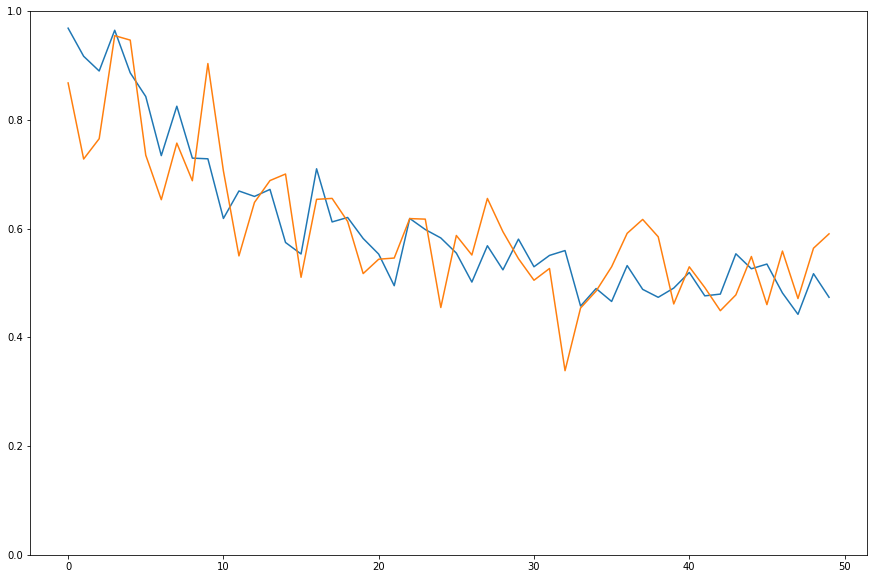

In [33]:
plt.figure(figsize=(15,10))
plt.plot(train_metrics, scaley=False)
plt.plot(valid_metrics, scaley=False)
plt.show()

## Get test data

In [132]:
test_img_ids = [f for f in os.listdir(test_image_dir) if os.path.isfile(os.path.join(test_image_dir, f))]

## Predict

In [145]:
all_preds = []

for i in range(0, len(test_img_ids), 20):
    
    test_img_list = [imread(test_image_dir + '/' + img_id) for img_id in test_img_ids[i:i+20]]
    
    test_exs = np.asarray(test_img_list, dtype=np.float32)
    
    predict_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'x':test_exs},
        batch_size=1,
        num_epochs=1,
        shuffle=False)
    
    predict_generator = cnn_model.predict(input_fn=predict_input_fn)
    predict_dictlist = [next(predict_generator) for i in range(len(test_exs))]

    preds = [predict_dictlist[item] for item in range(len(predict_dictlist))]
        
    lst = []
    
    for item in preds:
        item = item > 0.9
        lst.append(rle_encode(item))
    
    all_preds.append(lst)

## RL-encode predicted masks

In [156]:
rle_preds = []

for lst in all_preds:
    for item in lst:
        rle_preds.append(item)

## Create submission file

In [159]:
submission = pd.DataFrame()
submission['ImageId'] = test_img_ids
submission['EncodedPixels'] = rle_preds

# sort dataframe by image_ids
submission = submission.sort_values(by='ImageId').reset_index().drop(columns='index')

# set index to start from 1
submission.index += 1

# save to file
submission.to_csv('submission.csv')